# Appendix 2
# Prediction of energy market prices mFRR

In this appendix you can see how the best model for mFRR prices forecasting was created.

## Importing the Data

In [1]:
from functools import reduce
import glob
import os

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
import warnings

from utils import get_time_of_day, get_season, weighted_mae

In [2]:
warnings.filterwarnings("ignore")

In [3]:
market_df = pd.read_csv("data/market_data.csv", index_col=0)
market_df.index = pd.to_datetime(market_df.index, utc=True)
print(market_df.shape)
market_df.head()

(11424, 100)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,LT_up_da_cbmp,LT_down_sa_cbmp,LT_down_da_cbmp,EE_dsb,LV_dsb,LT_dsb,EE_imbalance_price,LV_imbalance_price,LT_imbalance_price,10YLT-1001A0008Q_DA_eurmwh
2025-03-01 00:00:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,927.02,120.48
2025-03-01 00:15:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,932.81,120.48
2025-03-01 00:30:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,NaN,NaN,NaN,1,-1.0,1.0,400.00,10.19,119.23,120.48
2025-03-01 00:45:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,400.00,10.19,-303.44,120.48
2025-03-01 01:00:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,560.36,10.19,-291.36,117.15


In [4]:
files = glob.glob("data/weather_location_*.csv")
dfs = []

for file in files:
    city = os.path.splitext(os.path.basename(file))[0].replace("weather_location_", "")
    df = pd.read_csv(file, index_col=0)
    df = df.rename(columns={col: f"{col}_{city}" for col in df.columns})
    
    dfs.append(df)

weather_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs)
weather_df.index = pd.to_datetime(weather_df.index, utc=True)
print(weather_df.shape)
weather_df.head()

(2856, 140)


,wind_speed_80m_Alytus,wind_speed_80m_previous_day1_Alytus,wind_direction_80m_Alytus,wind_direction_80m_previous_day1_Alytus,direct_radiation_Alytus,direct_radiation_previous_day1_Alytus,diffuse_radiation_Alytus,diffuse_radiation_previous_day1_Alytus,cloud_cover_Alytus,cloud_cover_previous_day1_Alytus,...,direct_radiation_Vilnius,direct_radiation_previous_day1_Vilnius,diffuse_radiation_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_Vilnius,relative_humidity_2m_previous_day1_Vilnius
2025-03-01 00:00:00+00:00,13.333627,13.684512,125.0,87.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,2.1235,1.8235,89.0,91.0
2025-03-01 01:00:00+00:00,12.280973,14.737166,123.0,99.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.9735,1.7735,89.0,91.0
2025-03-01 02:00:00+00:00,13.333627,12.631857,118.0,101.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.8735,1.8235,89.0,90.0
2025-03-01 03:00:00+00:00,11.228318,9.473893,130.0,102.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.7735,1.8235,89.0,89.0
2025-03-01 04:00:00+00:00,9.123008,7.368583,152.0,87.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.9235,1.7235,90.0,90.0


## Cleaning and Preparing the Data for the Model

Lets remove the columns if more than 50% of data are missing. Since there are some `NaN`s values in target column I will fill them with the average of its neighbouring values. The other `NaN` LightGBM handles internaly.

In [5]:
percent_missing = 0.5
market_df_filtered = market_df.loc[:, market_df.isnull().mean() < percent_missing]
print(market_df_filtered.shape)
market_df_filtered.head()

(11424, 68)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,LT_up_da_cbmp,LT_down_sa_cbmp,LT_down_da_cbmp,EE_dsb,LV_dsb,LT_dsb,EE_imbalance_price,LV_imbalance_price,LT_imbalance_price,10YLT-1001A0008Q_DA_eurmwh
2025-03-01 00:00:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,927.02,120.48
2025-03-01 00:15:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,932.81,120.48
2025-03-01 00:30:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,NaN,NaN,NaN,1,-1.0,1.0,400.00,10.19,119.23,120.48
2025-03-01 00:45:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,400.00,10.19,-303.44,120.48
2025-03-01 01:00:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,560.36,10.19,-291.36,117.15


In [6]:
market_df_filtered["LT_up_sa_cbmp"].isna().sum()

424

In [7]:
market_df_filtered.loc[:, "LT_up_sa_cbmp"] = market_df_filtered["LT_up_sa_cbmp"].interpolate(
    method="linear", limit_direction="both"
)

In [8]:
market_df_filtered["LT_up_sa_cbmp"].isna().sum()

0

In [9]:
targets = ["10YLT-1001A0008Q_DA_eurmwh", "LT_up_sa_cbmp", "LT_down_sa_cbmp"]
target = targets[1]
features =  [col for col in market_df_filtered.columns if col not in targets]

lagged_market = market_df_filtered[features].shift(2)
lagged_market.head()

,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,LV_up_sa_cbmp,LV_down_sa_cbmp,LT_up_da_cbmp,LT_down_da_cbmp,EE_dsb,LV_dsb,LT_dsb,EE_imbalance_price,LV_imbalance_price,LT_imbalance_price
2025-03-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-01 00:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-01 00:30:00+00:00,1.818,0.018,3.048,0.0,2.05,0.0,400.0,927.0,-273.0,20.0,...,27.27,27.27,NaN,NaN,1.0,-1.0,1.0,400.0,10.19,927.02
2025-03-01 00:45:00+00:00,1.729,0.000,3.547,0.0,2.40,0.0,400.0,400.0,-273.0,20.0,...,27.27,27.27,NaN,NaN,1.0,-1.0,1.0,400.0,10.19,932.81
2025-03-01 01:00:00+00:00,1.070,0.000,3.506,0.0,0.38,1.5,400.0,927.0,-273.0,20.0,...,27.27,27.27,NaN,NaN,1.0,-1.0,1.0,400.0,10.19,119.23


In [10]:
weather_upsampled = weather_df.loc[weather_df.index.repeat(4)].copy()
weather_upsampled.index = market_df_filtered.index
merged_df = pd.concat([
    lagged_market,
    market_df_filtered[["10YLT-1001A0008Q_DA_eurmwh"]], 
    weather_upsampled,
    market_df_filtered[["LT_up_sa_cbmp"]] 
], axis=1)

print(merged_df.shape)
merged_df.head(8)

(11424, 207)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,direct_radiation_previous_day1_Vilnius,diffuse_radiation_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_Vilnius,relative_humidity_2m_previous_day1_Vilnius,LT_up_sa_cbmp
2025-03-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,100.0,100.0,2.1235,1.8235,89.0,91.0,27.27
2025-03-01 00:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,100.0,100.0,2.1235,1.8235,89.0,91.0,27.27
2025-03-01 00:30:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,0.0,0.0,0.0,100.0,100.0,2.1235,1.8235,89.0,91.0,27.27
2025-03-01 00:45:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,0.0,0.0,0.0,100.0,100.0,2.1235,1.8235,89.0,91.0,27.27
2025-03-01 01:00:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,0.0,0.0,0.0,100.0,100.0,1.9735,1.7735,89.0,91.0,27.27
2025-03-01 01:15:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,0.0,0.0,0.0,100.0,100.0,1.9735,1.7735,89.0,91.0,27.27
2025-03-01 01:30:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,0.0,0.0,0.0,100.0,100.0,1.9735,1.7735,89.0,91.0,27.27
2025-03-01 01:45:00+00:00,3.061,0.000,3.315,0.0,0.00,2.38,400.0,927.0,-273.0,20.0,...,0.0,0.0,0.0,100.0,100.0,1.9735,1.7735,89.0,91.0,27.27


In [11]:
df = merged_df.copy()

df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month
df["time_of_day"] = df["hour"].apply(get_time_of_day)
df["season"] = df["month"].apply(get_season)
df["time_of_day"] = df["time_of_day"].astype("category")
df["season"] = df["season"].astype("category")

print(df.shape)
df.head()

(11424, 212)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,temperature_2m_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_Vilnius,relative_humidity_2m_previous_day1_Vilnius,LT_up_sa_cbmp,hour,dayofweek,month,time_of_day,season
2025-03-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.1235,1.8235,89.0,91.0,27.27,0,5,3,night,spring
2025-03-01 00:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.1235,1.8235,89.0,91.0,27.27,0,5,3,night,spring
2025-03-01 00:30:00+00:00,1.818,0.018,3.048,0.0,2.05,0.0,400.0,927.0,-273.0,20.0,...,2.1235,1.8235,89.0,91.0,27.27,0,5,3,night,spring
2025-03-01 00:45:00+00:00,1.729,0.000,3.547,0.0,2.40,0.0,400.0,400.0,-273.0,20.0,...,2.1235,1.8235,89.0,91.0,27.27,0,5,3,night,spring
2025-03-01 01:00:00+00:00,1.070,0.000,3.506,0.0,0.38,1.5,400.0,927.0,-273.0,20.0,...,1.9735,1.7735,89.0,91.0,27.27,1,5,3,night,spring


In [12]:
features =  [col for col in df.columns if col not in targets]
df = df.sort_index()

split_idx = int(len(df) * 0.8)
X_train = df[features].iloc[:split_idx]
y_train = df[targets[1]].iloc[:split_idx]
X_test = df[features].iloc[split_idx:]
y_test = df[targets[1]].iloc[split_idx:]

## LightGBM
As you will see below XGBoost, LightGBM, CatBoost are not performing so well on the mFRR data. These data is a bit too spiky.

In [13]:
tscv = TimeSeriesSplit(n_splits=3)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

model_lgbm = LGBMRegressor(
    random_state=9,
    subsample=0.8,
    subsample_freq=1,
    n_jobs=-1
)

param_grid_lgbm = {
    "n_estimators": [50, 100, 200, 300, 400],
    "max_depth": [2, 3, 4],
    "learning_rate": [0.005, 0.01, 0.025, 0.5],
    "colsample_bytree": [0.1, 0.2, 0.3, 0.4],
}


grid_search_lgbm = GridSearchCV(
    estimator=model_lgbm,
    param_grid=param_grid_lgbm,
    scoring=mae_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

grid_search_lgbm.fit(X_train, y_train)

print("Best parameters (LGBM):", grid_search_lgbm.best_params_)
print("Best MAE CV (LGBM):", -grid_search_lgbm.best_score_)

y_pred_train = grid_search_lgbm.best_estimator_.predict(X_train)
y_pred_lgbm = grid_search_lgbm.best_estimator_.predict(X_test)
mae_test_lgbm = mean_absolute_error(y_test, y_pred_lgbm)

print("Test MAE (LGBM):", round(mae_test_lgbm, 4))

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38850
[LightGBM] [Info] Number of data points in the train set: 9139, number of used features: 210
[LightGBM] [Info] Start training from score 48.895829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

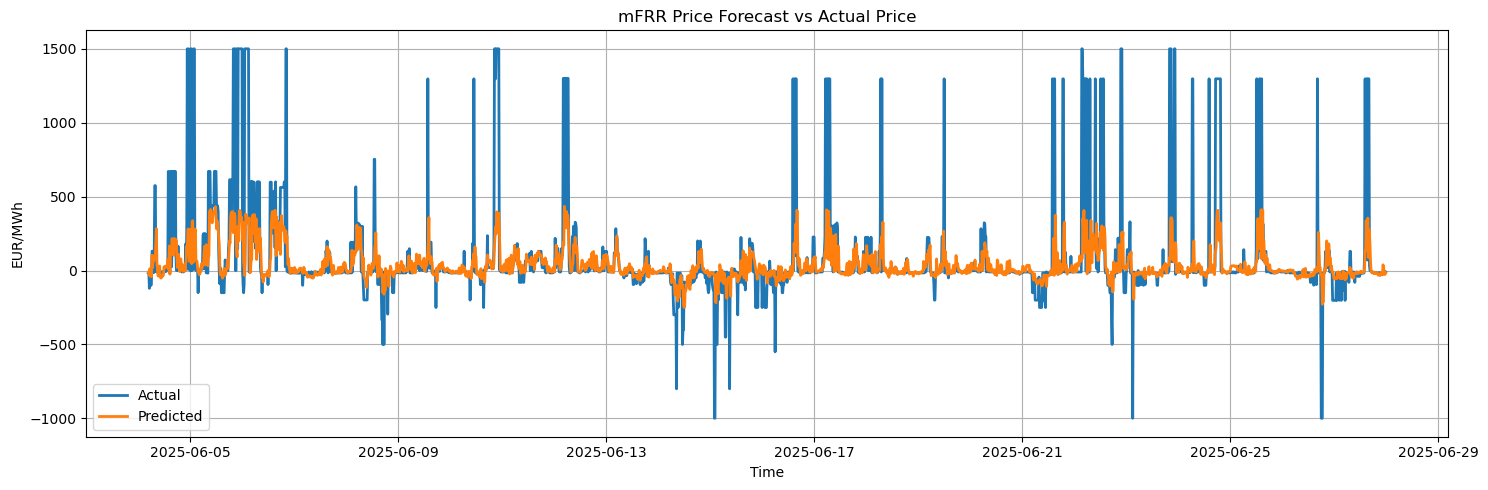

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, y_pred_lgbm, label="Predicted", linewidth=2)
plt.title("mFRR Price Forecast vs Actual Price")
plt.xlabel("Time")
plt.ylabel("EUR/MWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Since the data has a lot of spikes lets try to improve the outcome by making a log transformation on the target variable. Before doing so let's look at the data and see what is a "spike" in the data. Let's plot the data and how far away from the mean is the spikes measured in standard deviations.

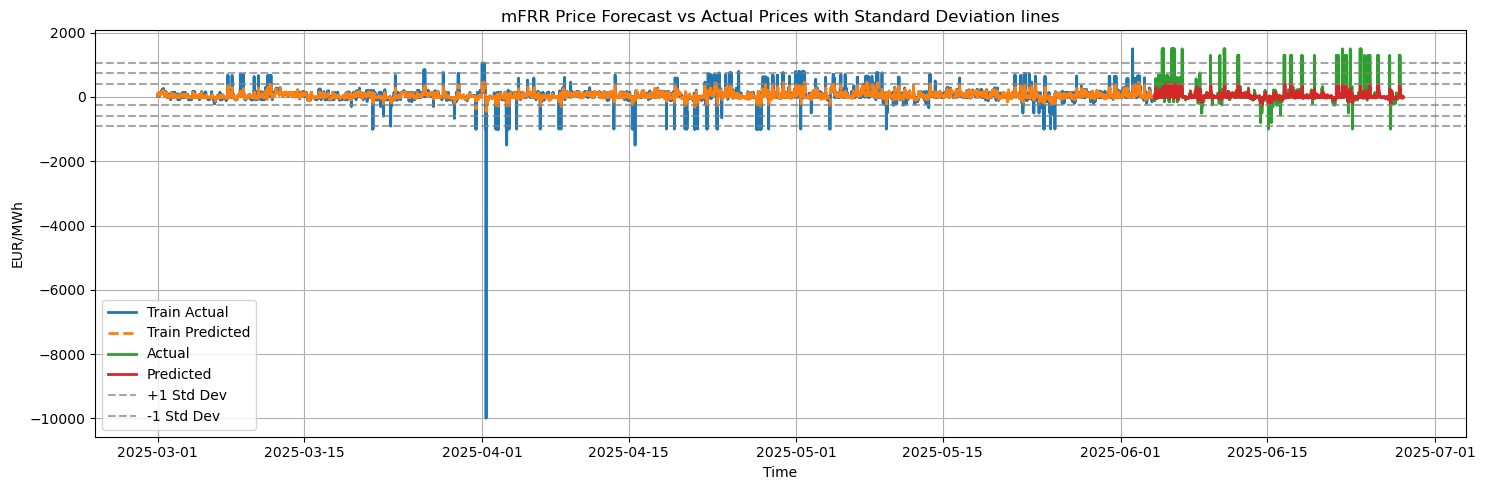

In [15]:
mean_val = y_test.mean()
std_val = y_test.std()

plt.figure(figsize=(15, 5))
plt.plot(y_train.index, y_train, label="Train Actual", linewidth=2)
plt.plot(y_train.index, y_pred_train, label="Train Predicted", linewidth=2, linestyle="--")
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, y_pred_lgbm, label="Predicted", linewidth=2)

for i in range(1, 4):
    plt.axhline(mean_val + i * std_val, color='gray', linestyle='--', alpha=0.7, label=f'+{i} Std Dev' if i == 1 else None)
    plt.axhline(mean_val - i * std_val, color='gray', linestyle='--', alpha=0.7, label=f'-{i} Std Dev' if i == 1 else None)

plt.title("mFRR Price Forecast vs Actual Prices with Standard Deviation lines")
plt.xlabel("Time")
plt.ylabel("EUR/MWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
df[df["LT_up_sa_cbmp"] == df["LT_up_sa_cbmp"].min()]

,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,temperature_2m_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_Vilnius,relative_humidity_2m_previous_day1_Vilnius,LT_up_sa_cbmp,hour,dayofweek,month,time_of_day,season
2025-04-01 09:00:00+00:00,0.0,0.742,0.0,3.587,0.0,0.0,400.0,400.0,20.0,20.0,...,13.8735,14.0735,47.0,44.0,-9999.0,9,1,4,morning,spring


Very interesting minimal value, but this anomally in the data it needs further investigation to find out if it was anomally or true value. For the purpose of this analyses and since it wouldn't have much influece on the model I will leave it in the data as it is.

From the graph we can see that the model finds peaks up to 1 sandard deviation, so anything that is above or below 1 standard deviation will be considered a "spike".

In [17]:

weighted_mae_scorer = make_scorer(weighted_mae, greater_is_better=False)

model_lgbm = LGBMRegressor(
    random_state=9,
    subsample=0.8,
    subsample_freq=1,
    n_jobs=-1
)

param_grid_lgbm = {
    "n_estimators": [200, 300, 400, 500, 600],
    "max_depth": [2, 3, 4],
    "learning_rate": [0.005, 0.01, 0.025, 0.5],
    "colsample_bytree": [0.2, 0.3, 0.4],
}


grid_search_lgbm = GridSearchCV(
    estimator=model_lgbm,
    param_grid=param_grid_lgbm,
    scoring=weighted_mae_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

grid_search_lgbm.fit(X_train, y_train)

print("Best parameters (LGBM):", grid_search_lgbm.best_params_)
print("Best MAE CV (LGBM):", -grid_search_lgbm.best_score_)

y_pred_train = grid_search_lgbm.best_estimator_.predict(X_train)
y_pred_lgbm = grid_search_lgbm.best_estimator_.predict(X_test)
mae_test_lgbm = mean_absolute_error(y_test, y_pred_lgbm)

print("Test MAE (LGBM):", round(mae_test_lgbm, 4))

Fitting 3 folds for each of 180 candidates, totalling 540 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38850
[LightGBM] [Info] Number of data points in the train set: 9139, number of used features: 210
[LightGBM] [Info] Start training from score 48.895829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

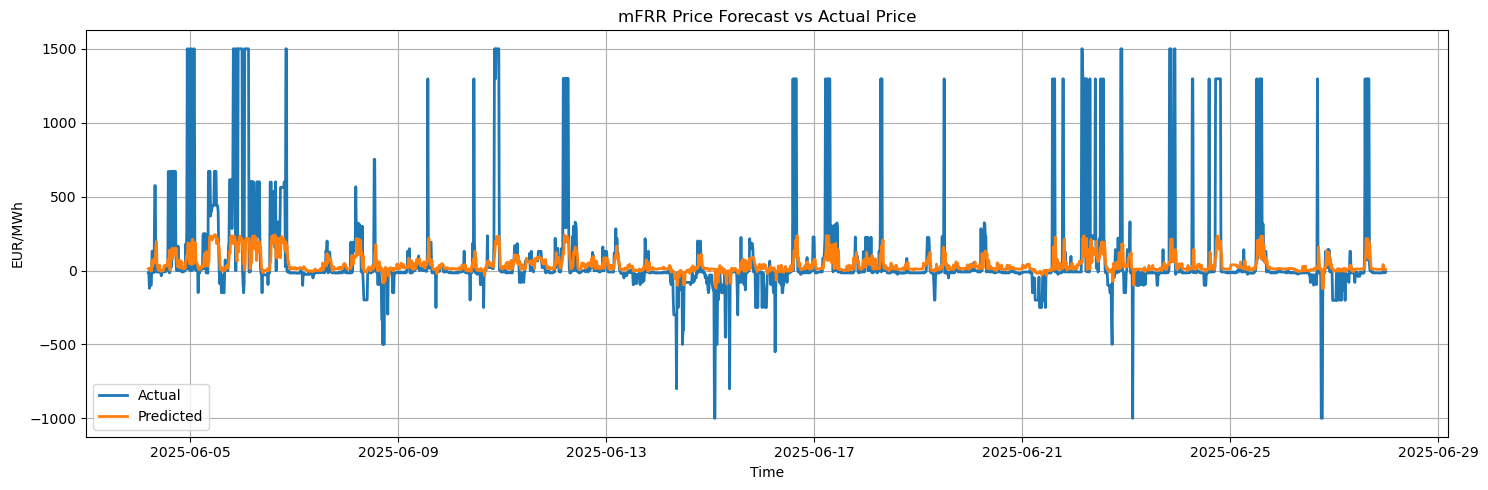

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, y_pred_lgbm, label="Predicted", linewidth=2)
plt.title("mFRR Price Forecast vs Actual Price")
plt.xlabel("Time")
plt.ylabel("EUR/MWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Let's try log scaling the target feature maybe the effect of spikes will not be so high.

In [23]:
shift = abs(df["LT_up_sa_cbmp"].min()) + 1
df["LT_up_sa_cbmp_log"] = np.log(df["LT_up_sa_cbmp"] + shift)

y_train = df["LT_up_sa_cbmp_log"].iloc[:split_idx]
y_test = df["LT_up_sa_cbmp_log"].iloc[split_idx:]

model_lgbm_log = LGBMRegressor(
    random_state=9,
    subsample=0.8,
    subsample_freq=1,
    n_jobs=-1
)

param_grid_lgbm_log = {
    "n_estimators": [50, 100, 200, 300, 400],
    "max_depth": [2, 3, 4],
    "learning_rate": [0.001, 0.005, 0.01, 0.025],
    "colsample_bytree": [0.1, 0.2, 0.3, 0.4],
}


grid_search_lgbm_log = GridSearchCV(
    estimator=model_lgbm_log,
    param_grid=param_grid_lgbm_log,
    scoring=weighted_mae_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

grid_search_lgbm_log.fit(X_train, y_train)

print("Best parameters (LGBM):", grid_search_lgbm_log.best_params_)
print("Best MAE CV (LGBM):", -grid_search_lgbm_log.best_score_)

y_pred_log_train = grid_search_lgbm_log.best_estimator_.predict(X_train)
y_pred_log_lgbm = grid_search_lgbm_log.best_estimator_.predict(X_test)

y_pred_log_lgbm_original = np.exp(y_pred_log_lgbm) - shift
y_test_original = np.exp(y_test) - shift

mae_test_lgbm_log = mean_absolute_error(y_test_original, y_pred_log_lgbm_original)
print("Test MAE (LGBM, original scale):", round(mae_test_lgbm_log, 4))

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38850
[LightGBM] [Info] Number of data points in the train set: 9139, number of used features: 210
[LightGBM] [Info] Start training from score 9.214147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

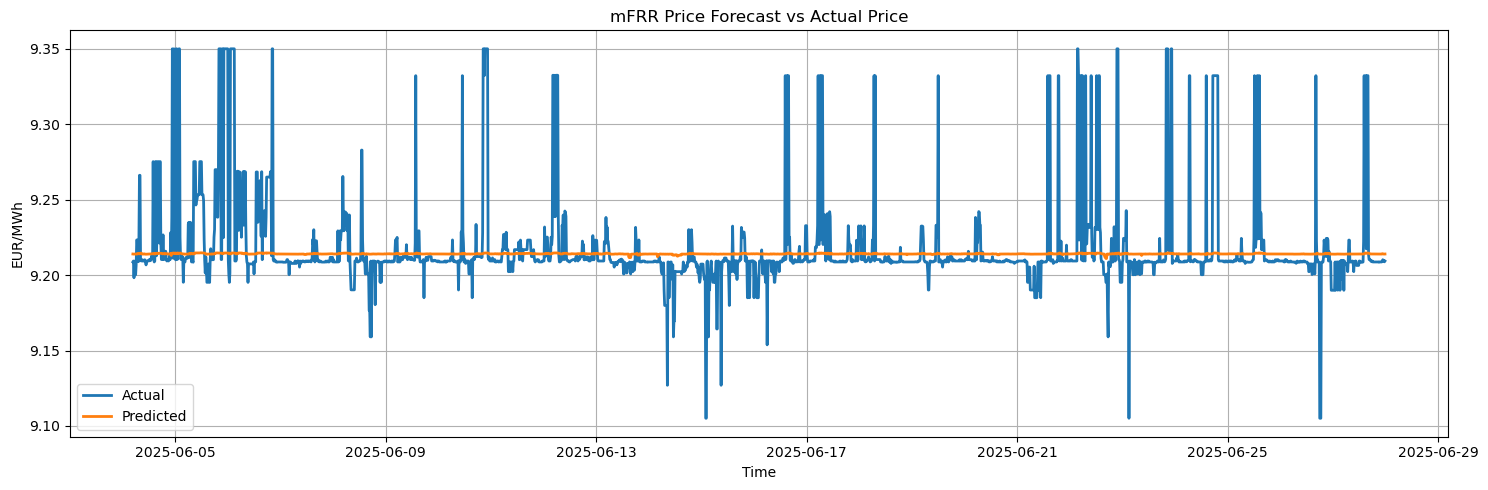

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, y_pred_log_lgbm, label="Predicted", linewidth=2)
plt.title("mFRR Price Forecast vs Actual Price")
plt.xlabel("Time")
plt.ylabel("EUR/MWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Neural Networks like LSTM could be an option to try, but it needs way more data than 11 000 rows, but it is good with spiky data. 